# Formative 3

In [1]:
import pickle
import re
from collections import defaultdict, Counter
from html import unescape

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from nltk import sent_tokenize
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.nn import functional as F

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
# Define function to clean and split text
def clean(text):
    text = unescape(text)
    return [re.sub('[^a-z0-9]', '', w.lower()) for w in text.strip().split()]

In [6]:
# Load dataframe
df = pd.read_csv('reddit_mbti.csv')

# Remove columns not needed for formative
df = df[['comment', 'type']]

# Remove empty comments
#df = df[df.comment.apply(lambda x: len(clean(x))) > 0]

In [11]:
df.head()

,comment,type
0,you really want to go down this path? Would y...,enfp
1,I think insurance companies do that. Once you...,intp
2,"I see it as 22,500 people working for about an...",intp
3,Our President stands ready to ride his golf ca...,intp
4,"Some write that he was trying to say ""big leag...",intp


In [6]:
# Define dictionary for particle look-up
p2id = {'over': 0, 'back': 1, 'around': 2, 'out': 3}

# Define dictionary for reverse particle look-up
id2p = {v: k for k, v in p2id.items()}

# Initialize lists for storing contexts around particles
sent_1 = list()
sent_2 = list()

# Initialize list for storing labels
labels = list()

# Loop over comments
for c in df.comment:
    
    # Loop over individual sentences
    for s in sent_tokenize(c):
        
        # Clean and split sentence
        split = clean(s)
        
        if len(split) < 10:
            continue
        
        # Add sentence to list if only one particle in sentence
        if len([w for w in split if w in p2id]) == 1:
            
            # Identify particle
            p = [w for w in split if w in p2id][0]

            # Store contexts and label
            sent_1.append(split[:split.index(p)])
            sent_2.append(split[split.index(p) + 1:])
            labels.append(p)

In [7]:
# Create dataframe with contexts and labels and perform stratified sampling
p_df = pd.DataFrame({'sent_1': sent_1, 'sent_2': sent_2, 'label': labels})[['sent_1', 'sent_2', 'label']]
p_df = p_df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=1500, random_state=0)).reset_index(drop=True)

In [8]:
# Split dataframe into training, evaluation, and test data
train, dev_test = train_test_split(p_df, test_size=0.2, stratify=p_df['label'], random_state=0)
dev, test = train_test_split(dev_test, test_size=0.5, stratify=dev_test['label'], random_state=0)

In [9]:
# Create dictionary for word look-up
word_counter = Counter([w for s in train.sent_1 for w in s] + [w for s in train.sent_2 for w in s])
w2id = {w: i + 2 for i, w in enumerate(w for w, c in word_counter.most_common())}

# Create dictionary for reverse word look-up
id2w = {i: w for w, i in w2id.items()}

In [10]:
# Define function to encode sentences
def encode(sent, w2id):
    return [w2id[w] if w in w2id else 1 for w in sent]

In [11]:
# Define function to pad sentences
def pad(sent):
    if len(sent) > 5:
        sent = sent[-5:]
    elif len(sent) < 5:
        sent = [0] * (5 - len(sent)) + sent
    return sent

In [12]:
# Encode and pad sentences
for data in [train, dev, test]:
    
    # Encode and pad left contexts
    data['enc_1'] = data.sent_1.apply(lambda x: pad(encode(x, w2id)))
    
    # Reverse order of right contexts prior to padding
    data['enc_2'] = data.sent_2.apply(lambda x: pad(encode(x, w2id)[::-1]))

In [13]:
# Define function for classifier training and evaluation
def train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device):
    
    # Define training objective
    criterion = nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = optim.Adam(classifier.parameters(), lr=0.01)
    
    # Move model and data to CUDA
    classifier = classifier.to(device)
    [train_x, train_y, dev_x, dev_y, test_x, test_y] = [data.to(device) for data in [train_x, train_y, dev_x, dev_y, test_x, test_y]]
    
    # Train model
    for epoch in range(1, 21):
        
        # Perform forward pass
        classifier.train()
        
        optimizer.zero_grad() # <--- 
        output = classifier(train_x)
        loss = criterion(output, train_y)
        
        # Perform backpropagation
        loss.backward()
        
        # Update model weights
        optimizer.step()
        
        # Evaluate model every fifth epoch
        if epoch % 5 == 0:

            classifier.eval() # <--- "what i'm donna do next"

            with torch.no_grad():
                    
                    # Perform forward pass
                    output =  classifier(dev_x)
                    
                    # Make prediction
                    max_output = output.argmax(dim=1, keepdim=True)
                    
                    # Compute accuracy
                    acc = max_output.squeeze(1).eq(dev_y).sum() / torch.FloatTensor([dev_y.shape[0]])

                    print('Accuracy on dev data after {:02d} epochs: {:.4f}'.format(epoch, acc.data.item()))
    
    # Test model
    classifier.eval()
        
    with torch.no_grad():
        
        # Perform forward pass
        output =  classifier(test_x)
        
        # Make prediction
        max_output = output.argmax(dim=1, keepdim=True)
        
        # Compute accuracy
        acc = max_output.squeeze(1).eq(test_y).sum() / torch.FloatTensor([test_y.shape[0]])
        
        print('Accuracy on test data: {:.4f}'.format(acc.data.item()))

    # Return labels and predictions
    return acc.data.item(), [l.item() for l in test_y], [p.item() for p in max_output]

In [19]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
### Part II: Logistic Regression Classifier

# Define logistic regression classifier class
class LRClassifier(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        
        super(LRClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

In [21]:
# Define function to convert context into sparse indicator vector
def sent2sparse(sent_1, sent_2, vocab):
    counter = Counter(sent_1 + sent_2)
    return [counter[w] for w in sorted(vocab)[:5000]]

In [22]:
# Define hyperparameters
input_dim = 5000
output_dim = 4

In [23]:
# Define range of context window sizes
ks = [1, 2, 3, 4, 5]

# Initialize lists for storing accuracies and top words
accs = list()
tops = list()

# Loop over context window sizes
for k in ks:
    
    print('Using context window size of {}...'.format(k))

    # Convert encoded and padded right and left context into sparse vectors
    for data in [train, dev, test]:
        data['sparse'] = data.apply(lambda x: sent2sparse(x.enc_1[-k:], x.enc_2[-k:], set(id2w.keys())), axis=1)

    # Transform all data to torch tensors
    train_x = torch.tensor(list(train['sparse'])).float()
    train_y = torch.tensor([p2id[p] for p in train.label])
    dev_x = torch.tensor(list(dev['sparse'])).float()
    dev_y = torch.tensor([p2id[p] for p in dev.label])
    test_x = torch.tensor(list(test['sparse'])).float()
    test_y = torch.tensor([p2id[p] for p in test.label])

    # Train and evaluate model
    classifier = LRClassifier(input_dim, output_dim)
    acc, true_lr, pred_lr = train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device)
    
    # Store accuracies and top words
    accs.append(acc)
    tops.append([[id2w[i+2] for i in l] for l in classifier.linear.weight.topk(k=10, dim=-1)[1].tolist()])

Using context window size of 1...
Accuracy on dev data after 05 epochs: 0.5717
Accuracy on dev data after 10 epochs: 0.5983
Accuracy on dev data after 15 epochs: 0.5850
Accuracy on dev data after 20 epochs: 0.5900
Accuracy on test data: 0.5833
Using context window size of 2...
Accuracy on dev data after 05 epochs: 0.5233
Accuracy on dev data after 10 epochs: 0.5350
Accuracy on dev data after 15 epochs: 0.5417
Accuracy on dev data after 20 epochs: 0.5533
Accuracy on test data: 0.5500
Using context window size of 3...
Accuracy on dev data after 05 epochs: 0.5233
Accuracy on dev data after 10 epochs: 0.5233
Accuracy on dev data after 15 epochs: 0.5317
Accuracy on dev data after 20 epochs: 0.5250
Accuracy on test data: 0.5083
Using context window size of 4...
Accuracy on dev data after 05 epochs: 0.4750
Accuracy on dev data after 10 epochs: 0.4850
Accuracy on dev data after 15 epochs: 0.5017
Accuracy on dev data after 20 epochs: 0.5067
Accuracy on test data: 0.4900
Using context window siz

**A) What accuracy would a classifier get that predicts classes based on random guesses? How
does the logistic regression classifier compare to that baseline?**

Given that we are dealing with 4 classes and balanced data, a classifier based on random guesses would get an accuracy of 25%. The accuracy of the logistic regression classifier is way above that random baseline.

**B) Plot the accuracy as a function of the context window size $k$. What do you observe? What conclusions can you draw regarding the linguistic information necessary for predicting particles?**


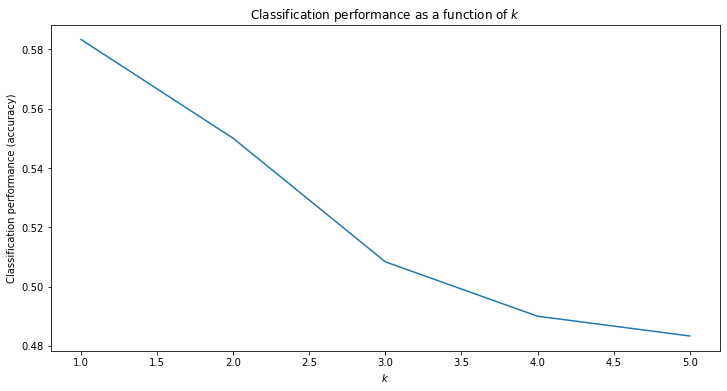

In [24]:

# Create plot of classification performance as a function of k
fig, ax = plt.subplots(1, figsize=(12, 6))

ax.plot(ks, accs)
ax.set_title('Classification performance as a function of $k$')
ax.set_xlabel('$k$')
ax.set_ylabel('Classification performance (accuracy)')

plt.show()

There is a direct link between the context window size and the classification performance, with smaller values of $k$ leading to better performance. This suggests that the narrow syntactic context is more predictive of particles than the broader topical context. Notice the parallel to word embedding training, where smaller context window sizes generally lead to embeddings that capture more syntactic information.

**C) For each $k$, examine the top 10 predictive words of each particle. Are your observations in line with the hypothesis made above?**

In [26]:
for k, top in zip(ks, tops):
    print('Context window size of {}:'.format(k))
    for i in range(4):
        print('Top predictive words for {}:'.format(id2p[i]), top[i])

Context window size of 1:
Top predictive words for over: ['republicans', 'parkinsons', 'planes', 'unify', '500', '54', 'nearly', 'map', 'crazies', 'threats']
Top predictive words for back: ['always', 'seat', 'winning', 'later', 'should', 'good', 'mean', 'building', 'never', 'weekends']
Top predictive words for around: ['scandals', 'actually', 'barely', 'bad', 'than', '100000', 'sentiment', 'roads', 'having', 'supporters']
Top predictive words for out: ['military', 'carry', 'ill', 'sent', 'crossed', 'looks', 'entirely', 'called', 'word', 'drops']
Context window size of 2:
Top predictive words for over: ['talking', 'scratch', 'quick', 'twice', 'drugs', 'fired', 'whose', 'hurt', 'talked', 'increase']
Top predictive words for back: ['strong', 'machine', '1000', 'overwhelming', 'bit', 'hundreds', 'few', 'says', 'invite', 'falls']
Top predictive words for around: ['youll', 'finish', 'criminal', 'tweets', 'head', 'bullshit', 'trying', 'everywhere', 'allegations', 'thank']
Top predictive words

In [27]:
for k, top in zip(ks, tops):
    print('Context window size of {}:'.format(k))
    for i in range(4):
        print('Top predictive words for {}:'.format(id2p[i]), top[i])

Context window size of 1:
Top predictive words for over: ['republicans', 'parkinsons', 'planes', 'unify', '500', '54', 'nearly', 'map', 'crazies', 'threats']
Top predictive words for back: ['always', 'seat', 'winning', 'later', 'should', 'good', 'mean', 'building', 'never', 'weekends']
Top predictive words for around: ['scandals', 'actually', 'barely', 'bad', 'than', '100000', 'sentiment', 'roads', 'having', 'supporters']
Top predictive words for out: ['military', 'carry', 'ill', 'sent', 'crossed', 'looks', 'entirely', 'called', 'word', 'drops']
Context window size of 2:
Top predictive words for over: ['talking', 'scratch', 'quick', 'twice', 'drugs', 'fired', 'whose', 'hurt', 'talked', 'increase']
Top predictive words for back: ['strong', 'machine', '1000', 'overwhelming', 'bit', 'hundreds', 'few', 'says', 'invite', 'falls']
Top predictive words for around: ['youll', 'finish', 'criminal', 'tweets', 'head', 'bullshit', 'trying', 'everywhere', 'allegations', 'thank']
Top predictive words

For smaller values of $k$, several of the most predictive words frequently occur in syntactic contexts with the particle (e.g., _cenetered around_). This is also the case for some larger values of $k$, but arguably to a lesser extent.

### Part III: Feed-forward Neural Network Classifier

In [28]:
# Define feed-forward neural network classifier class
class FNNClassifier(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim):
        
        super(FNNClassifier, self).__init__()
        self.linear_1 = nn.Linear(input_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = torch.tanh(self.linear_1(x))
        return self.linear_2(h)

In [29]:
# Convert encoded and padded right and left context into sparse vectors
for data in [train, dev, test]:
    data['sparse'] = data.apply(lambda x: sent2sparse(x.enc_1[-1:], x.enc_2[-1:], set(id2w.keys())), axis=1)

# Transform all data to torch tensors
train_x = torch.tensor(list(train.sparse)).float()
train_y = torch.tensor([p2id[p] for p in train.label])
dev_x = torch.tensor(list(dev.sparse)).float()
dev_y = torch.tensor([p2id[p] for p in dev.label])
test_x = torch.tensor(list(test.sparse)).float()
test_y = torch.tensor([p2id[p] for p in test.label])

AttributeError: Can only use the '.sparse' accessor with Sparse data.

In [ ]:
# Define hyperparameters
input_dim = 5000
output_dim = 4

In [ ]:
# Define range of dimensions
ds = [5, 10, 50, 100, 500]

# Initialize lists for storing accuracies
accs = list()

# Loop over dimensions
for d in ds:
    
    print('Using hidden dimension of {:03d}...'.format(d))

    # Train and evaluate model
    classifier = FNNClassifier(input_dim, output_dim, d)
    acc, true_ffn, pred_ffn = train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device)
    
    # Store accuracies
    accs.append(acc)

In [ ]:
# Rerun with best dimension
classifier = FNNClassifier(input_dim, output_dim, 50)
acc, true_ffn, pred_ffn = train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device)

In [ ]:
# Inspect cases of wrong logistic regression predictions and correct feed-forward neural network predictions
n = 5

for s_1, s_2, l, p_lr, p_ffn in zip(test.sent_1, test.sent_2, true_lr, pred_lr, pred_ffn):
    if l != p_lr and l == p_ffn:
        print(id2p[l], id2p[p_lr], id2p[p_ffn])
        print('\t'.join(s_1[-5:]), '\t\t', '\t'.join(s_2[:5]))
        print()
        n -= 1

    if n == 0:
        break  

**A) How
does this classifier compare to the logistic regression classifier?**

For tuned $d$, the feed-forward neural network classifier performs better than the logistic regression classifier. For the best value of $d$, the difference amounts to 2%.

**B) Plot the accuracy as a function of the hidden dimension $d$. What do you observe?**

In [ ]:
# Create plot of classification performance as a function of k
fig, ax = plt.subplots(1, figsize=(12, 6))

ax.plot(ds, accs)
ax.set_title('Classification performance as a function of $d$')
ax.set_xlabel('$d$')
ax.set_ylabel('Classification performance (accuracy)')

plt.show()

The best performance is reached with $d = 50$. For smaller values, the performance of the feed-forward neural network classifier is similar or worse than the logistic regression classifier. For larger values, the performance does not improve further and is a bit worse than at the peak value. When repeating the hyperparameter search multiple times, $d = 100$ sometimes performs better than $d = 50$.

### Part IV: LSTM Classifier

In [30]:
# Define LSTM classifier class
class LSTMClassifier(nn.Module):
    
    # Pass hyperparameters as arguments
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout, context):
        
        super(LSTMClassifier, self).__init__()
        
        self.context = context
        
        if self.context in {'left', 'both'}:
        
            # Define embedding and LSTM layers for left context (batch_dim x 5 -> batch x 5 x embedding_dim -> batch_dim x hidden_dim)
            self.embedding_1 = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
            self.lstm_1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
            
        if self.context in {'right', 'both'}:
            
            # Define embedding and LSTM layers for right context (batch_dim x 5 -> batch x 5 x embedding_dim -> batch_dim x hidden_dim)
            self.embedding_2 = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
            self.lstm_2 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
            
        if self.context in {'left', 'right'}:
        
            # Define dense layer (batch_dim x hidden_dim -> batch_dim x output_dim)
            self.linear = nn.Linear(hidden_dim, output_dim)
            
        if self.context == 'both':
            
            # Define dense layer (batch_dim x 2 * hidden_dim -> batch_dim x output_dim)
            self.linear = nn.Linear(2 * hidden_dim, output_dim)
        
        # Define dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        sent_1, sent_2 = torch.chunk(x, 2, dim=-1)
        
        if self.context in {'left', 'both'}:
            
            # Define flow through embedding and LSTM layers for left context
            emb_1 = self.dropout(self.embedding_1(sent_1))
            output_1, (hidden_1, cell_1) = self.lstm_1(emb_1)
            
        if self.context in {'right', 'both'}:
            
            # Define flow through embedding and LSTM layers for right context            
            emb_2 = self.dropout(self.embedding_2(sent_2))            
            output_2, (hidden_2, cell_2) = self.lstm_2(emb_2)
            
        if self.context == 'left':
            
            # Pass through dense layer
            output = self.linear(self.dropout(output_1[:, -1, :]))
            
        if self.context == 'right':
            
            # Pass through dense layer
            output = self.linear(self.dropout(output_2[:, -1, :]))
            
        if self.context == 'both':
        
            # Concatenate and pass through dense layer
            output = self.linear(self.dropout(torch.cat((output_1[:, -1, :], output_2[:, -1, :]), dim=-1)))
        
        return output

In [31]:
# Transform all data to torch tensors
train_x = torch.cat((torch.tensor(list(train.enc_1)), torch.tensor(list(train.enc_2))), dim=-1) 
train_y = torch.tensor([p2id[p] for p in train.label])
dev_x = torch.cat((torch.tensor(list(dev.enc_1)), torch.tensor(list(dev.enc_2))), dim=-1)
dev_y = torch.tensor([p2id[p] for p in dev.label])
test_x = torch.cat((torch.tensor(list(test.enc_1)), torch.tensor(list(test.enc_2))), dim=-1)
test_y = torch.tensor([p2id[p] for p in test.label])

In [34]:
train

,sent_1,sent_2,label,enc_1,enc_2,sparse
1118,"[sandy, had]","[100b, in, funding, and, it, affected, way, mo...",around,"[0, 0, 0, 3031, 80]","[11, 4, 1051, 8, 5248]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
852,"[so, once, shes, there, theres, no, reason, to...","[even, if, you, buy, into, the, fallacy, that,...",around,"[62, 276, 3, 203, 11]","[91, 465, 13, 22, 72]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1431,"[as, a, result, they, gained, extraterritorial...","[the, world]",around,"[745, 371, 3920, 8, 2504]","[0, 0, 0, 131, 2]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4981,"[theyre, the, ones, paying, all, these, politi...","[so, they, can, price, gouge, necessities, for...",over,"[153, 516, 3, 263, 74]","[9339, 1625, 50, 14, 32]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3221,"[payment, for, class, a, drugs, , 1mhowever, w...",[],out,"[870, 39, 10, 2508, 27]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
5757,"[the, fact, that, a, contested, convention, is...","[on, the, first, ballot]",over,"[9, 39, 5, 1091, 158]","[0, 2607, 172, 2, 16]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2982,"[the, last, two, gop, presidential, nominees, ...","[to, the, center, in, time, for, the, national...",back,"[900, 3, 87, 7, 213]","[61, 8, 1514, 2, 3]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3808,"[im, not, old, by, any, terms, but, i, swear, ...","[curled, up, in, a, ball, unable, to, stop, co...",out,"[67, 3, 3783, 47, 67]","[2355, 5, 8, 47, 12852]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1447,"[a, few, of, the, women]","[my, campus, who, are, muslim, have, told, me,...",around,"[5, 169, 6, 2, 359]","[861, 21, 46, 12853, 53]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Define hyperparameters
input_dim = len(w2id) + 2
embedding_dim = 300
hidden_dim = 200
output_dim = 4
dropout = 0.5

In [ ]:
# Train and test on both contexts
classifier = LSTMClassifier(input_dim, embedding_dim, hidden_dim, output_dim, dropout, 'both')
acc, true_b, pred_b = train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device)

In [ ]:
# Inspect cases of wrong feed-forward neural network predictions and correct LSTM predictions
n = 5

for s_1, s_2, l, p_ffn, p_lstm in zip(test.sent_1, test.sent_2, true_ffn, pred_ffn, pred_b):
    if l != p_ffn and l == p_lstm:
        print(id2p[l], id2p[p_ffn], id2p[p_lstm])
        print('\t'.join(s_1[-5:]), '\t\t', '\t'.join(s_2[:5]))
        print()
        n -= 1

    if n == 0:
        break  

**A) How
does the LSTM classifier compare to the feed-forward neural network classifier?**

The LSTM outperforms the feed-forward neural network classifier substantially, leading to a performance improvement of 8%.

**B)  Modify the LSTM architecture so that it only takes the left or right context into account. Train and test these two models. Which of the two contexts provides more information for
particle prediction?**

In [ ]:
# Train and test on left contexts
classifier = LSTMClassifier(input_dim, embedding_dim, hidden_dim, output_dim, dropout, 'left')
acc, true_l, pred_l = train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device)

In [ ]:
# Train and test on right contexts
classifier = LSTMClassifier(input_dim, embedding_dim, hidden_dim, output_dim, dropout, 'right')
acc, true_r, pred_r = train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device)

Both models perform worse than the particle classifier trained on both contexts. The model trained on the right context performs substantially better than the one trained on the left context.

**C) Tabulate the number of misclassified examples as a function of the number of UNK tokens
in the left and right contexts. Manually inspect a couple of misclassified examples. What do
you observe? How do your observations relate to results of earlier parts of the formative?**

In [ ]:
unk_counter = defaultdict(Counter)

for c_l, c_r, l, p in zip(test.enc_1, test.enc_2, true_b, pred_b):
    unk_counter[len([i for i in c_l if i == 1])]['left_f'] += int(l != p)
    unk_counter[len([i for i in c_r if i == 1])]['right_f'] += int(l != p)
    unk_counter[len([i for i in c_l if i == 1])]['left_c'] += int(l == p)
    unk_counter[len([i for i in c_r if i == 1])]['right_c'] += int(l == p)
    
for n in unk_counter:
    total = sum(unk_counter[n].values())
    unk_counter[n] = {t: unk_counter[n][t] / total for t in unk_counter[n]}

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar([x - 0.3 for x in range(3)], [unk_counter[n]['left_c'] for n in range(3)], 0.2, label='Left context correct')
ax.bar([x - 0.1 for x in range(3)], [unk_counter[n]['left_f'] for n in range(3)], 0.2, label='Left context false')
ax.bar([x + 0.1 for x in range(3)], [unk_counter[n]['right_c'] for n in range(3)], 0.2, label='Right context correct')
ax.bar([x + 0.3 for x in range(3)], [unk_counter[n]['right_f'] for n in range(3)], 0.2, label='Right context false')

ax.xaxis.set_ticks([0, 1, 2, 3])
ax.set_xlabel('Number of UNK tokens')
ax.set_ylabel('Share of examples')
ax.set_title('Examples by number of UNK tokens and context type')

ax.legend(loc='upper left')

plt.show()

In [ ]:
# Print five misclassified examples with two UNK tokens
n = 5

for s_1, s_2, c_l, c_r, l, p in zip(test.sent_1, test.sent_2, test.enc_1, test.enc_2, true_b, pred_b):
    if (len([i for i in c_l if i == 1]) == 2 or len([i for i in c_r if i == 1]) == 2) and l != p:
        print(id2p[l], id2p[p])
        print('\t'.join(s_1[-5:]), '\t\t', '\t'.join(s_2[:5]))
        print('\t'.join([str(t) for t in c_l]), '\t\t', '\t'.join([str(t) for t in c_r][::-1]))
        print()
        n -= 1

    if n == 0:
        break      

The number of UNK tokens has a negative influence on the model performance. The effect is more pronounced for the right context. In addition, it is interesting to note that most of the UNK tokens occurred close to the particle. This is in line with the observation made above that the nearest words are most predictive of the particle.

**D) Create a confusion matrix of the predicted labels versus the true labels. What do you
observe?**

In [ ]:
for labels, preds in [(true_b, pred_b), (true_l, pred_l), (true_r, pred_r)]:
    
    # Initialize confuction matrix
    c_matrix = defaultdict(Counter)

    # Create confusion matrix
    for l, p in zip(labels, preds):
        c_matrix[id2p[l]][id2p[p]] += 1

    # Display confusion matrix
    print(pd.DataFrame.from_dict(c_matrix, orient='index', columns=list(p2id.keys())).reindex(index=list(p2id.keys())))
    
    print()

For all three models, most misclassifications occurred for _around_. Also, all three models have a relatively low number of errors for _back_.

### Part V: Overall Discussion

**Compare the three models to the trigram model presented in class. What information is available for the classifier in each of the four approaches? Are you able to interpret the overall
success of the models in relation to the information that is available in each one and the ability
to exploit it in an optimal fashion?**

The performance of the logistic regression classifier is similar to the trigram model presented in class. For a fair comparison, we need to look at the model using a window size of two, which is only slightly better than the trigram model. The feed-forward neural network is already substantially better than the trigram model. It has a much larger model capacity, i.e., much more trainable parameters, than the trigram model, which allows it to capture the patterns in the data with a greater detail. As opposed to the logistic regression and the feed-forward neural network classfiers, the LSTM has information about the order of words, which is crucial for the task of particle prediction and hence leads to a large performance increase.